# Forecasting the Price of Silver
## Exploratory Data Analysis

**Import all the relevant packages.** 

In [1]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

### Data Cleaning/Wrangling

**Read into variables data from the dataset.**

In [4]:
slv = pd.read_csv('data/SLV.csv')

**Review data to ensure proper implementation.**

In [5]:
slv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,15.25,15.64,15.19,15.44,15.44,11033700
1,2017-01-04,15.58,15.66,15.49,15.58,15.58,6142900
2,2017-01-05,15.73,15.85,15.66,15.76,15.76,7785600
3,2017-01-06,15.57,15.70,15.55,15.64,15.64,6097900
4,2017-01-09,15.69,15.83,15.65,15.70,15.70,7288900


**Check that data conforms to expectations.**

In [6]:
slv.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,17.717601,17.841493,17.573614,17.711477,17.711477,1.802589e+07
std,3.822863,3.873093,3.746981,3.814378,3.814378,1.862329e+07
min,11.340000,11.440000,10.860000,11.210000,11.210000,2.423800e+06
25%,15.070000,15.165000,15.020000,15.080000,15.080000,7.065250e+06
50%,16.150000,16.260000,16.040001,16.150000,16.150000,1.211190e+07
75%,21.410000,21.585000,21.200001,21.405001,21.405001,2.300390e+07
max,27.760000,27.980000,26.570000,27.000000,27.000000,2.806150e+08


**Format date as *Datetime* and set date as index.**

In [7]:
fmt = '%Y-%m-%d' 
slv['Date']=pd.to_datetime(slv['Date'],format=fmt)
slv.set_index(pd.DatetimeIndex(slv['Date']),inplace=True)

**Check for null values.**

In [8]:
slv.isnull().values.any()

False

**Verify redundant column and remove it**

In [9]:
slv[slv['Close']!=slv['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,


In [ ]:
slv.drop(['Adj Close'],axis=1,inplace=True)

**Add column representing trading day**

In [10]:
slv['Day'] = np.arange(1,len(slv)+1)
slv = slv[['Day','Open','Low','High','Close','Volume']]
slv.head()

,Day,Open,Low,High,Close,Volume
Date,,,,,,
2017-01-03,1,15.25,15.19,15.64,15.44,11033700
2017-01-04,2,15.58,15.49,15.66,15.58,6142900
2017-01-05,3,15.73,15.66,15.85,15.76,7785600
2017-01-06,4,15.57,15.55,15.70,15.64,6097900
2017-01-09,5,15.69,15.65,15.83,15.70,7288900


In [11]:
path = 'data/slv_working.pkl'
with open(path, 'wb') as f:
    pickle.dump(slv,f)

### Exploratory Data Analysis

**Graph the data.**

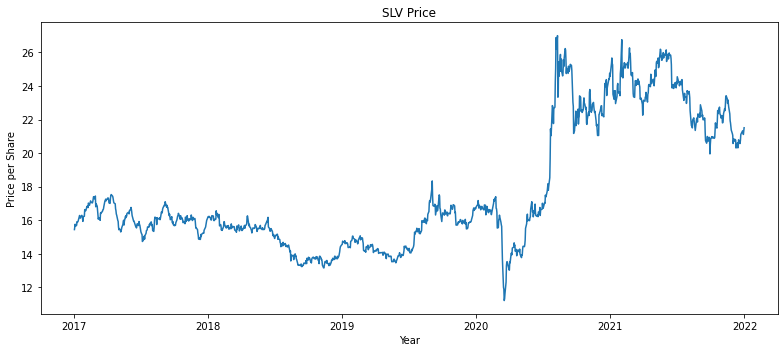

In [13]:
fig1, ax = plt.subplots(1,1,figsize=(11,5))
ax.plot(slv.index,slv['Close'])
ax.set_xlabel('Year')
ax.set_ylabel('Price per Share')
ax.set_title('SLV Price')
fig1.tight_layout()
fig1.savefig('plots/fig1.png')

**Compare data with GLD (Gold) and SPY (Large Cap Index)**

In [14]:
# Read in comparison data
gld = pd.read_csv('data/GLD.csv')
spy = pd.read_csv('data/SPY.csv')
fmt = '%Y-%m-%d' 
gld['Date']=pd.to_datetime(gld['Date'],format=fmt)
gld.set_index(pd.DatetimeIndex(gld['Date']),inplace=True)
spy['Date']=pd.to_datetime(spy['Date'],format=fmt)
spy.set_index(pd.DatetimeIndex(spy['Date']),inplace=True)

# Calculate percent change from beginning of dataset
slv0 = slv.loc['2017-01-03','Close']
gld0 = gld.loc['2017-01-03','Close']
spy0 = spy.loc['2017-01-03','Close']
silver = (slv['Close'] - slv0)/slv0
gold = (gld['Close'] - gld0)/gld0
market = (spy['Close'] - spy0)/spy0

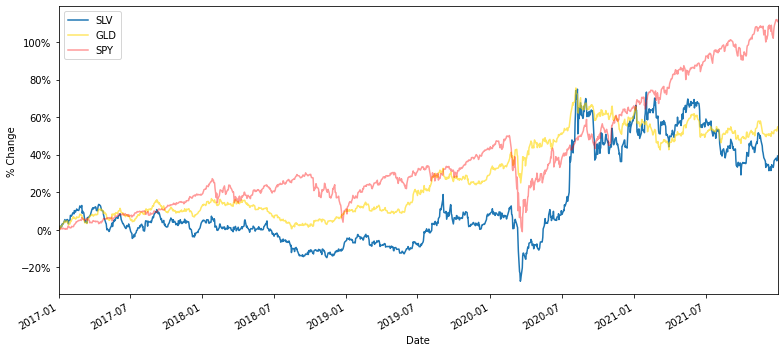

In [15]:
import matplotlib.ticker as tick
fig2, ax = plt.subplots(1,1,figsize=(11,5))
xmin, xmax = datetime.date(2017,1,1), datetime.date(2021,12,31)
silver.plot(label='SLV',xlim=[xmin,xmax])
gold.plot(color='gold',alpha=0.6,label='GLD',xlim=[xmin,xmax])
market.plot(color='red',alpha=0.4,label='SPY',xlim=[xmin,xmax])
ax.yaxis.set_major_formatter(tick.PercentFormatter(1,decimals=0))
ax.legend(loc='best')
ax.set_ylabel('% Change')
fig2.tight_layout()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

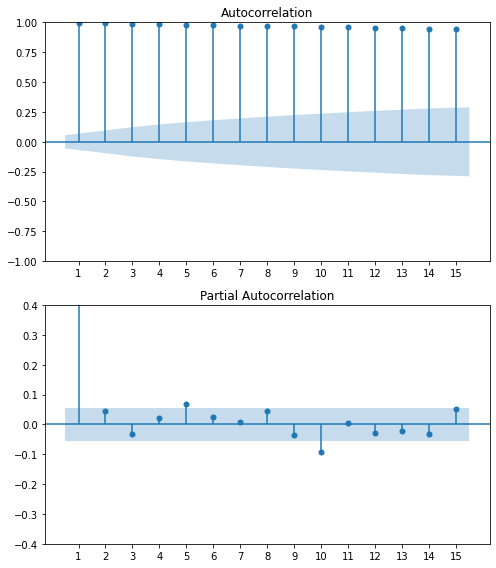

In [16]:
data = slv['Close']
ticks = np.arange(1,16) 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,8))
plot_acf(data,alpha=0.05,lags=ticks, ax=ax1)
plot_pacf(data,alpha=0.05,lags=ticks, ax=ax2, method='yw')
ax1.set_xticks(ticks)
ax2.set_ylim([-0.4,0.4])
ax2.set_xticks(ticks)
fig.tight_layout()

**SLV exhibits very slight fall-off in autocorrelation on a daily basis. However, in the partial
autocorrelation plot (PACF), only lag 1 shows a significant correlation.**

**Test for stationarity**

In [17]:
from statsmodels.tsa.stattools import adfuller,kpss
adf_result = adfuller(slv['Close'])
print(f'Augmented Dickey-Fuller test p-value: {adf_result[1]}')

Augmented Dickey-Fuller test p-value: 0.5624844926718228


**SLV data is not stationary**

**Thus, the first difference is taken, producing well-stationarized data**

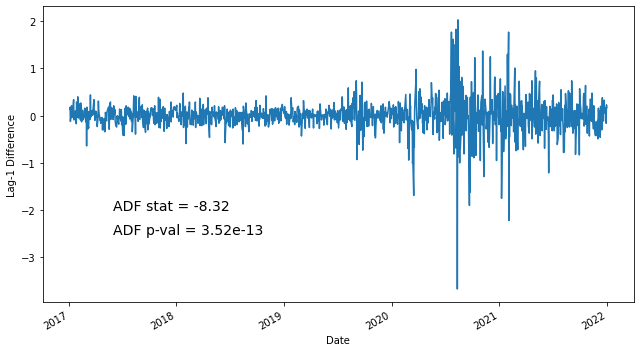

In [18]:
fig3, ax = plt.subplots(1,1,figsize=(9,5))
slv_dif1 = slv['Close'].diff().dropna()
adf_result = adfuller(slv_dif1)
slv_dif1.plot(figsize=(9,5))
ax.text(datetime.date(2017,6,1),-2,f'ADF stat = {adf_result[0]:.2f}',fontsize=14)
ax.text(datetime.date(2017,6,1),-2.5,f'ADF p-val = {adf_result[1]:.2e}',fontsize=14)
ax.set_ylabel('Lag-1 Difference')
fig3.tight_layout()
fig3.savefig('plots/fig3.png')

**KPSS results can't reject null hypothesis of trend-stationarity, confirming ADF result.**

In [20]:
kpss_result = kpss(slv_dif1,nlags='auto',regression='ct')
print(f'Kwiatkowski-Phillips-Schmidt-Shin test results: {kpss_result[0],kpss_result[1]}')

Kwiatkowski-Phillips-Schmidt-Shin test results: (0.057610247344390325, 0.1)


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Autocorrelation and Partial Autocorrelation Factor Plots for differenced data**

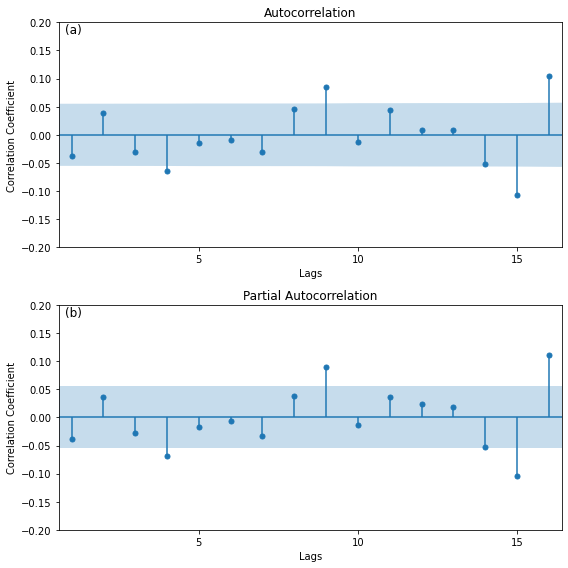

In [21]:
data = slv_dif1
fig4, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
plot_acf(data,alpha=0.05,lags=16,ax=ax1)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlim(0.6,16.4)
ax1.set_xticks([5,10,15])
ax1.text(0.8,0.18,'(a)',fontsize=12)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation Coefficient')
plot_pacf(data,alpha=0.05,lags=16,ax=ax2,method='yw')
ax2.set_ylim(-0.2,0.2)
ax2.set_xlim(0.6,16.4)
ax2.set_xticks([5,10,15])
ax2.text(0.8,0.18,'(b)',fontsize=12)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation Coefficient')
fig4.tight_layout()
fig4.savefig('plots/fig4.png')

## Summary ##
- **Significant correlation at lags 4, 9, 15, 16 in both ACF and PACF plots**
- **PACF plot showing similar pattern as ACF plot**
- **Model classification from the plot is not obvious**